# iFood CRM Data Analyst Case

__Author__ : Daniela A. Nomura \
__E-mail__ : daninomura@gmail.com \
__Date__: November 30th, 2020 

In this notebook we have studied a Pilot CRM Campaign where 2.240 randomly selected customers were contacted by phone regarding the acquisition of a gadget. In order to make the next campaign the most profitable as possible, we carried a detailed study based on the data of the last 5 campaigns and customer's informations and historic behavior. 
Our study is divided into 3 major parts:
- 1. Exploratory Data Analysis
- 2. Customer's segmentation based on historical behavior
- 3. Predictive model to improve the profit of the campaign

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PowerTransformer

%matplotlib inline

# 1. Exploring the data

## 1.1 Reading and checking the data

In [2]:
#Reading the data
data = pd.read_csv("ml_project1_data.csv")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
data.shape

(2240, 29)

We have a DataFrame with **2240 rows** and **29 columns**. Let's check if we have duplicate customers:

In [4]:
data.ID.nunique()

2240

As there is no duplicate ID, we can move on with the exploratory analysis. So, let's check the Data Types of the columns and if they are consistent 

In [5]:
#Checking the Data Types of the columns
data.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [6]:
#Let's check if any data is missing
print(data.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


As we can see, we have 24 income data missing. We will deal with it later

In [7]:
#Let's check the unique values of the variables
print(data.nunique())

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64


The columns *Z_CostContact* and *Z_revenue* have the same value for all rows (Z_CostContact = 3 and Z_revenue=11), so I will drop them from the dataframe

In [8]:
#Dropping the columns Z_CostContact and Z_Revenue 
data=data.drop(['Z_CostContact', 'Z_Revenue'], axis = 1)

## 1.2 Campaigns overview

Considering that all the 2,240 customers were contacted, regardless of missing (like in the income) or meaningless values on the features and as the "AcceptedCmp_" columns have no missing values and have only boolean values, let's take a look on that. 

In [9]:
#Separate the customers that accepted the offer at least once
Campaigns = data[(data.AcceptedCmp1 + data.AcceptedCmp2 + data.AcceptedCmp3 + data.AcceptedCmp4 + data.AcceptedCmp5) >=1]

In [10]:
#Accepted offers per campaign
camp2=pd.DataFrame()
camp2['camp1'] = [Campaigns.AcceptedCmp1.sum()]
camp2['camp2'] = [Campaigns.AcceptedCmp2.sum()]
camp2['camp3'] = [Campaigns.AcceptedCmp3.sum()]
camp2['camp4'] = [Campaigns.AcceptedCmp4.sum()]
camp2['camp5'] = [Campaigns.AcceptedCmp5.sum()]
camp2

,camp1,camp2,camp3,camp4,camp5
0,144,30,163,167,163


## 1.3 Cleaning and preparing the data

In [11]:
#Let's see some statistical details of our numeric data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


In [12]:
#Let's transform the the Dt_Customer data into datetime, so we can use day, month and year in case we need 
data["Dt_Customer"]=pd.to_datetime(data.Dt_Customer)

In [13]:
#From the Dt_Customer values I will calculate for how many years from today the customer has been enrolled with the company
data["Years_Customer"] = ((dt.today()-data.Dt_Customer).dt.days)/365.25

In [14]:
#Let's check the Education and the frequency they appear in the dataset
data.groupby("Education")["ID"].nunique().sort_values(ascending = False)

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: ID, dtype: int64

In [15]:
#Let's do the same for the Marital Status
data.groupby("Marital_Status")["ID"].nunique().sort_values(ascending = False)

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: ID, dtype: int64

As we can see at Marital_Status values, there are 3 values that are not clear for me the meaning: **Alone, Absurd and YOLO**, fortunately, they only represent 0,31% of the data, but for now I will replace them by **"Other"**:



In [16]:
data['Marital_Status']=data['Marital_Status'].replace(['Alone','Absurd','YOLO'],'Other')
data.groupby("Marital_Status")["ID"].nunique().sort_values(ascending = False)

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Other         7
Name: ID, dtype: int64

In [17]:
#I will add 2 columns with numerical values for the categorical variables: 
data['Marital_ID']=data['Marital_Status'].replace(['Single','Together','Married', 'Divorced','Widow','Other'],[0,1,2,3,4,5])
data['Education_ID']=data['Education'].replace(['Basic','2n Cycle','Graduation', 'Master','PhD'],[0,1,2,3,4])

In [18]:
#Marital Status ID equivalente
Marital=data.groupby('Marital_ID')['Marital_Status'].unique()
pd.DataFrame({'Marital_ID':Marital.index, 'Marital_Status':Marital.values})

,Marital_ID,Marital_Status
0,0,[Single]
1,1,[Together]
2,2,[Married]
3,3,[Divorced]
4,4,[Widow]
5,5,[Other]


In [19]:
#Education ID equivalente
Education=data.groupby('Education_ID')['Education'].unique()
pd.DataFrame({'Education_ID':Education.index, 'Education':Education.values})

,Education_ID,Education
0,0,[Basic]
1,1,[2n Cycle]
2,2,[Graduation]
3,3,[Master]
4,4,[PhD]


In [20]:
#Let's calculated the customers approximately age based on today's year and the Year_Birth values:
today = dt.now()
data['Approx_age']=(today.year - data.Year_Birth)

In [21]:
#Let's see some statistical details of our numeric data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.000000,2828.250000,5458.500000,8427.750000,11191.000000
Year_Birth,2240.0,1968.805804,11.984069,1893.000000,1959.000000,1970.000000,1977.000000,1996.000000
Income,2216.0,52247.251354,25173.076661,1730.000000,35303.000000,51381.500000,68522.000000,666666.000000
Kidhome,2240.0,0.444196,0.538398,0.000000,0.000000,0.000000,1.000000,2.000000
Teenhome,2240.0,0.506250,0.544538,0.000000,0.000000,0.000000,1.000000,2.000000
Recency,2240.0,49.109375,28.962453,0.000000,24.000000,49.000000,74.000000,99.000000
MntWines,2240.0,303.935714,336.597393,0.000000,23.750000,173.500000,504.250000,1493.000000
MntFruits,2240.0,26.302232,39.773434,0.000000,1.000000,8.000000,33.000000,199.000000
MntMeatProducts,2240.0,166.950000,225.715373,0.000000,16.000000,67.000000,232.000000,1725.000000
MntFishProducts,2240.0,37.525446,54.628979,0.000000,3.000000,12.000000,50.000000,259.000000


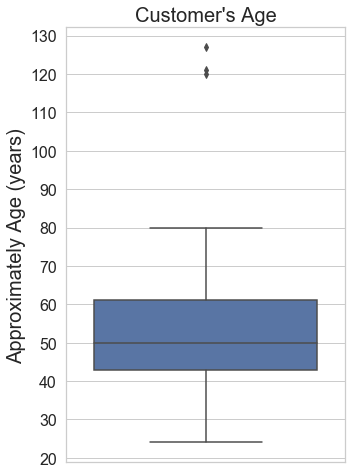

In [22]:
#As the maximum age seems to be too high, let's take a look on the age values spread using a Box Plot:
sns.set(style = 'whitegrid',rc={'figure.figsize':(5,8)})
ax = sns.boxplot(y=data.Approx_age)
ax.axes.set_title("Customer's Age",fontsize=20)
ax.set_ylabel("Approximately Age (years)",fontsize=20)
ax.tick_params(labelsize=16)
ax.yaxis.set_major_locator(plt.MultipleLocator(10)) 

*Figure 1:* Box plot with the approximately age spread.  

We can see a minimum value at 24 years old and maximum value at 80 years old, excluding the ouliers close to 120 years old. The median age is 50 years old. 25% of the customers are under 43 years old, 75% are under 61 years old and 25% are between 61 and 80 years old.   

In [23]:
#Age quantiles
data.Approx_age.quantile([0.25,0.5,0.75])

0.25    43.0
0.50    50.0
0.75    61.0
Name: Approx_age, dtype: float64

In [24]:
#Excluding the outliers from the DataFrame:
mask_age = data.Approx_age > 90
data2 = data[~mask_age]
data2.shape

(2237, 31)

Excluding the 3 outliers with age greater than 90 years old, we have now 2237 rows.

In [25]:
#Excluding the 24 missing income values:
mask_income = data2.Income.isnull()
data3 = data2[~mask_income]
data3.shape

(2213, 31)

In [26]:
data3['Campaing'] =(data3.AcceptedCmp1 + data3.AcceptedCmp2 + data3.AcceptedCmp3 + data3.AcceptedCmp4 + data3.AcceptedCmp5)

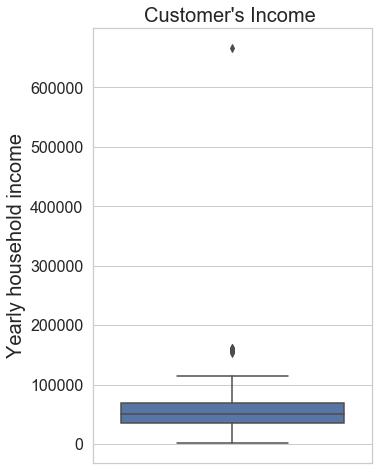

In [27]:
#Box Plot of the Yearly household income:
sns.set(style = 'whitegrid',rc={'figure.figsize':(5,8)})
ax = sns.boxplot(y=data3.Income)
ax.axes.set_title("Customer's Income ",fontsize=20)
ax.set_ylabel("Yearly household income",fontsize=20)
ax.tick_params(labelsize=16)

*Figure 2:* Box plot with the yearly household income spread.

In [28]:
max_inc = max(data3.Income)
min_inc = min(data3.Income)
print ("Maximum income:", max_inc)
print ("Minimum income:", min_inc)

Maximum income: 666666.0
Minimum income: 1730.0


Here we can also see some outliers values for the yearly income, but the one above 600000 is really far from the rest. I will exclude that value from the dataframe, as it is 6x bigger than the maximum representative value, also, the value of 666666 is a little bit suspicious of being unreal. 

In [29]:
#Excluding the suspicious high income value
mask_inc = data3.Income>300000
data4 = data3[~mask_inc]
data4.shape

(2212, 32)

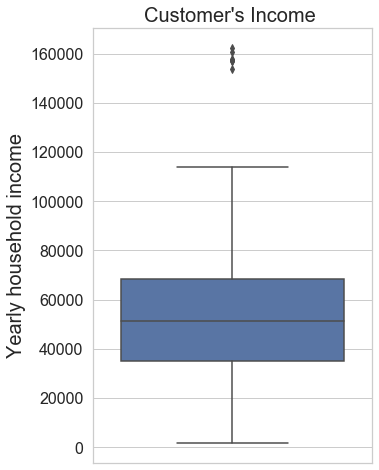

In [30]:
#Box Plot of the Yearly household income:
sns.set(style = 'whitegrid',rc={'figure.figsize':(5,8)})
ax = sns.boxplot(y=data4.Income)
ax.axes.set_title("Customer's Income ",fontsize=20)
ax.set_ylabel("Yearly household income",fontsize=20)
ax.tick_params(labelsize=16)

*Figure 3:* Box plot with the yearly household income spread after removing the highest outlier

By now there would be no reason to exclude the outiliers close to the 160000 yearly income. 25% of the clients have the yearly household income until 35233.5; the median value is 51371 and 75% of customers have the yearly income below 68487. 

In [31]:
#Age quantiles
data4.Income.quantile([0.25,0.5,0.75])

0.25    35233.5
0.50    51371.0
0.75    68487.0
Name: Income, dtype: float64

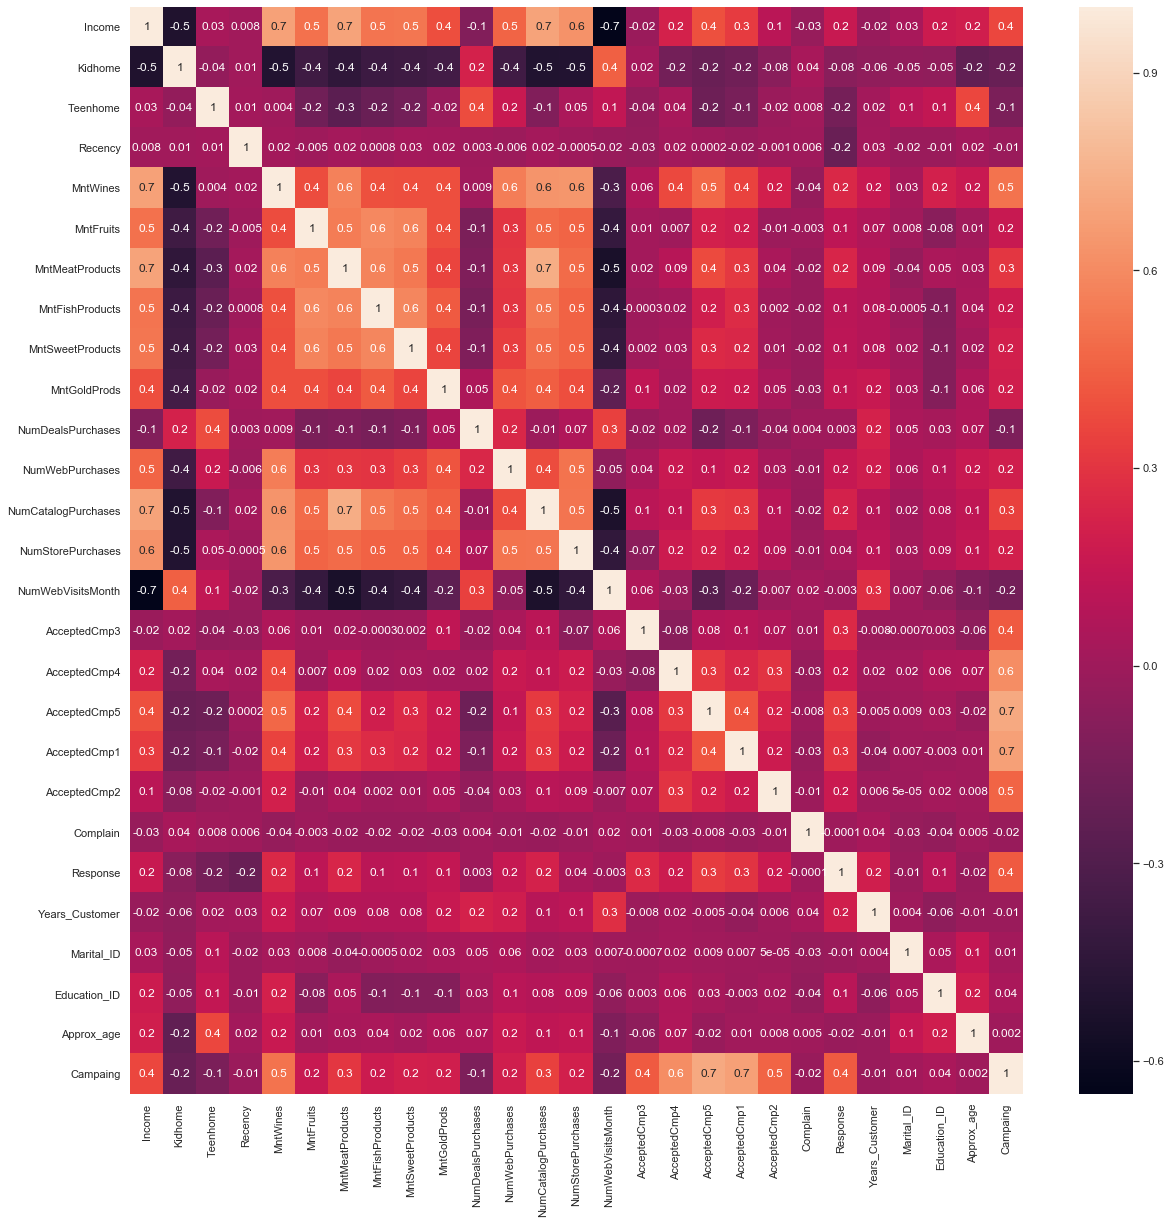

In [32]:
#Let's check if we have variables with high correlation
data5 = data4.drop(['Education','Year_Birth','Marital_Status','Dt_Customer','ID'],axis=1) #Drop the Columns we don't need

#Plor the Correlation matrix
corrMatrix = data5.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True, fmt='.1g')
plt.show()

*Figure 4:* Correlation Matrix

As we can see the highest correlation between two variables is 0.7, so I won't discard any of the features. 

In [33]:
#Save the last DataFrame to use in the second part of this Study
data_final = data4

## 1.4 Customer's profile

In [34]:
#Let's split the data:

# Customers who accepted the offer at least once
mask_camp = (data_final.Campaing >= 1)
acc = data_final[mask_camp]

# Customers who never accepted the offer
no_acc = data_final[~mask_camp]

In [35]:
acc.shape

(458, 32)

In [36]:
#Let's compre the two groups regarding the Education level
group_acc=acc.groupby(["Education_ID","Education"])["ID"].nunique().reset_index()
group_no=no_acc.groupby(["Education"])["ID"].nunique().reset_index()
group_acc["perc_acc"] = 100*(group_acc.ID/(group_acc.ID.sum()))
group_no["perc_no"] = 100*(group_no.ID/(group_no.ID.sum()))

Education_group=(pd.merge(group_acc,group_no,on='Education'))
Education_group = Education_group.rename(columns = {'ID_x': 'quant_acc', 'ID_y': 'quant_no'}, inplace = False)
print(Education_group)

   Education_ID   Education  quant_acc   perc_acc  quant_no    perc_no
0             0       Basic          6   1.310044        48   2.736602
1             1    2n Cycle         37   8.078603       161   9.179019
2             2  Graduation        228  49.781659       887  50.570125
3             3      Master         74  16.157205       291  16.590650
4             4         PhD        113  24.672489       367  20.923603


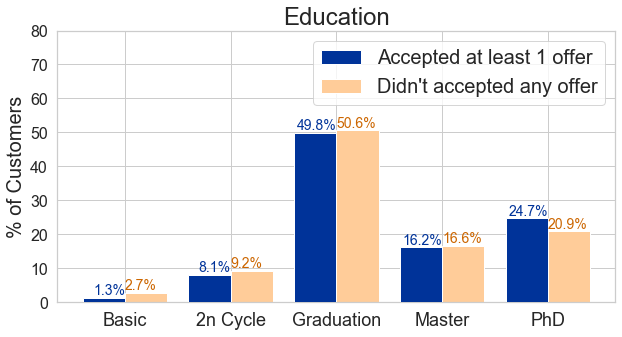

In [37]:
#plot a barplot of the two groups together
fig, ax = plt.subplots(figsize = (10,5))
vtext = np.vectorize(ax.text)

x1 = Education_group.Education
y1 = Education_group.perc_acc

x2 = Education_group.Education
y2 = Education_group.perc_no



rects1 = ax.bar(x1,y1,width =-0.4,label='Accepted at least 1 offer',zorder=3,color='#003399',align='edge')

rects2 = ax.bar(x1,y2,width =0.4,label="Didn't accepted any offer",zorder=2,color='#ffcc99',align='edge')

for i in range(len(y1)):  
    ax.text(x1[i], y1[i]+1,np.str(np.round(y1[i],decimals=1)) + '%',fontsize =14,ha= 'right',color='#003399',rotation='horizontal')
    ax.text(x2[i],y2[i]+1,np.str(np.round(y2[i],decimals=1)) + '%',fontsize = 14,ha= 'left',color='#cc6600',rotation='horizontal')


# organizing the labels and axis
ax.set_ylabel('% of Customers',fontsize=20)
ax.set_title('Education',fontsize=24)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()

ax.set_ylim(0,80)
plt.xticks(fontsize = 18,rotation='horizontal')
plt.yticks(fontsize = 16)

ax.grid(zorder=0)
ax.legend(fontsize=20)

*Figure 5:* Education level of the customers who accepted at least one offer x customers who didn't accepted any offer

In [38]:
#Now we do the same concerning the Marital Status
group_acc=acc.groupby(['Marital_ID',"Marital_Status"])["ID"].nunique().reset_index()
group_no=no_acc.groupby("Marital_Status")["ID"].nunique().reset_index()

group_acc["perc_acc"] = 100*(group_acc.ID/(group_acc.ID.sum()))
group_no["perc_no"] = 100*(group_no.ID/(group_no.ID.sum()))
Marital_group=(pd.merge(group_acc,group_no,on='Marital_Status'))
Marital_group = Marital_group.rename(columns = {'ID_x': 'quant_acc', 'ID_y': 'quant_no'}, inplace = False)
print(Marital_group)

   Marital_ID Marital_Status  quant_acc   perc_acc  quant_no    perc_no
0           0         Single         97  21.179039       373  21.265678
1           1       Together        114  24.890830       457  26.054732
2           2        Married        181  39.519651       676  38.540479
3           3       Divorced         46  10.043668       185  10.547320
4           4          Widow         18   3.930131        58   3.306727
5           5          Other          2   0.436681         5   0.285063


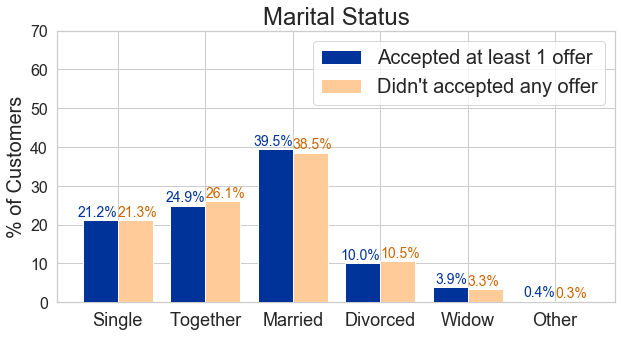

In [39]:
fig, ax = plt.subplots(figsize = (10,5))
vtext = np.vectorize(ax.text)

x1 = Marital_group.Marital_Status
y1 = Marital_group.perc_acc

x2 = Marital_group.Marital_Status
y2 = Marital_group.perc_no



rects1 = ax.bar(x1,y1,width =-0.4,label='Accepted at least 1 offer',zorder=3,color='#003399',align='edge')

rects2 = ax.bar(x1,y2,width =0.4,label="Didn't accepted any offer",zorder=2,color='#ffcc99',align='edge')

for i in range(len(y1)):  
    ax.text(x1[i], y1[i]+1,np.str(np.round(y1[i],decimals=1)) + '%',fontsize =14,ha= 'right',color='#003399',rotation='horizontal')
    ax.text(x2[i],y2[i]+1,np.str(np.round(y2[i],decimals=1)) + '%',fontsize = 14,ha= 'left',color='#cc6600',rotation='horizontal')


# organizing the labels and axis

ax.set_ylabel('% of Customers',fontsize=20)
ax.set_title('Marital Status',fontsize=24)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()

ax.set_ylim(0,70)
plt.xticks(fontsize = 18,rotation='horizontal')
plt.yticks(fontsize = 16)

ax.grid(zorder=0)
ax.legend(fontsize=20)

*Figure 6:* Marital Status of the customers who accepted at least one offer x customers who didn't accepted any offer

In [40]:
#Let's see how the number of children at home is different between the groups
group_acc=acc.groupby(["Kidhome"])["ID"].nunique().reset_index()
group_no=no_acc.groupby("Kidhome")["ID"].nunique().reset_index()

group_acc["perc_acc"] = 100*(group_acc.ID/(group_acc.ID.sum()))
group_no["perc_no"] = 100*(group_no.ID/(group_no.ID.sum()))
Kid_group=(pd.merge(group_acc,group_no,on='Kidhome'))
Kid_group = Kid_group.rename(columns = {'ID_x': 'quant_acc', 'ID_y': 'quant_no'}, inplace = False)
print(Kid_group)

   Kidhome  quant_acc   perc_acc  quant_no    perc_no
0        0        356  77.729258       925  52.736602
1        1         99  21.615721       786  44.811859
2        2          3   0.655022        43   2.451539


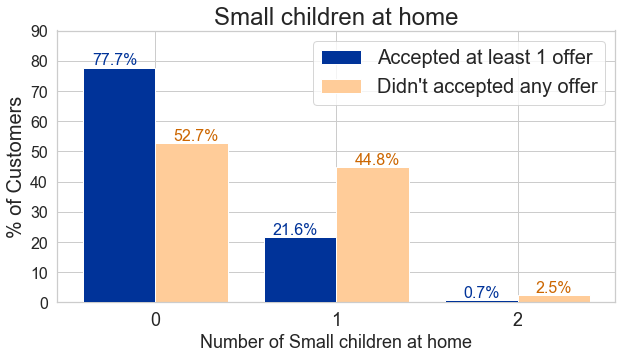

In [41]:
fig, ax = plt.subplots(figsize = (10,5))
vtext = np.vectorize(ax.text)

x1 = Kid_group.Kidhome
y1 = Kid_group.perc_acc

x2 = Kid_group.Kidhome
y2 = Kid_group.perc_no



rects1 = ax.bar(x1,y1,width =-0.4,label='Accepted at least 1 offer',zorder=3,color='#003399',align='edge')

rects2 = ax.bar(x1,y2,width =0.4,label="Didn't accepted any offer",zorder=2,color='#ffcc99',align='edge')

for i in range(len(y1)):  
    ax.text(x1[i]-0.1, y1[i]+1,np.str(np.round(y1[i],decimals=1)) + '%',fontsize =16,ha= 'right',color='#003399',rotation='horizontal')
    ax.text(x2[i]+0.1,y2[i]+1,np.str(np.round(y2[i],decimals=1)) + '%',fontsize = 16,ha= 'left',color='#cc6600',rotation='horizontal')


# organizing the labels and axis
ax.set_xlabel('Number of Small children at home',fontsize=18)
ax.set_ylabel('% of Customers',fontsize=20)
ax.set_title('Small children at home',fontsize=24)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()

ax.set_ylim(0,90)
plt.xticks(fontsize = 18,rotation='horizontal')
plt.yticks(fontsize = 16)

ax.grid(zorder=0)
ax.legend(fontsize=20)


*Figure 7:* Number of small children at home of the customers who accepted at least one offer x customers who didn't accepted any offer. As we can see, a higher percentage of the customers who accepted the offer don't have small children at home. 

In [42]:
#The same with the number of teenagers at home
group_acc=acc.groupby(["Teenhome"])["ID"].nunique().reset_index()
group_no=no_acc.groupby("Teenhome")["ID"].nunique().reset_index()

group_acc["perc_acc"] = 100*(group_acc.ID/(group_acc.ID.sum()))
group_no["perc_no"] = 100*(group_no.ID/(group_no.ID.sum()))
Teen_group=(pd.merge(group_acc,group_no,on='Teenhome'))
Teen_group = Teen_group.rename(columns = {'ID_x': 'quant_acc', 'ID_y': 'quant_no'}, inplace = False)
print(Teen_group)

   Teenhome  quant_acc   perc_acc  quant_no    perc_no
0         0        285  62.227074       859  48.973774
1         1        163  35.589520       854  48.688712
2         2         10   2.183406        41   2.337514


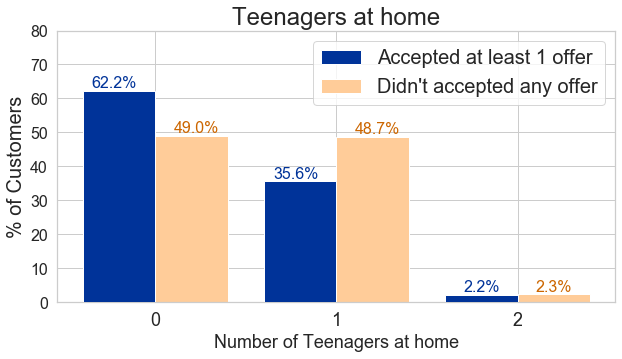

In [43]:
fig, ax = plt.subplots(figsize = (10,5))
vtext = np.vectorize(ax.text)

x1 = Teen_group.Teenhome
y1 = Teen_group.perc_acc

x2 = Teen_group.Teenhome
y2 = Teen_group.perc_no



rects1 = ax.bar(x1,y1,width =-0.4,label='Accepted at least 1 offer',zorder=3,color='#003399',align='edge')

rects2 = ax.bar(x1,y2,width =0.4,label="Didn't accepted any offer",zorder=2,color='#ffcc99',align='edge')

for i in range(len(y1)):  
    ax.text(x1[i]-0.1, y1[i]+1,np.str(np.round(y1[i],decimals=1)) + '%',fontsize =16,ha= 'right',color='#003399',rotation='horizontal')
    ax.text(x2[i]+0.1,y2[i]+1,np.str(np.round(y2[i],decimals=1)) + '%',fontsize = 16,ha= 'left',color='#cc6600',rotation='horizontal')


# organizing the labels and axis
ax.set_xlabel('Number of Teenagers at home',fontsize=18)
ax.set_ylabel('% of Customers',fontsize=20)
ax.set_title('Teenagers at home',fontsize=24)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend()

ax.set_ylim(0,80)
plt.xticks(fontsize = 18,rotation='horizontal')
plt.yticks(fontsize = 16)

ax.grid(zorder=0)
ax.legend(fontsize=20)

*Figure 8:* Number of Teenagers at home of the customers who accepted at least one offer x customers who didn't accepted any offer. As we can see, a higher percentage of the customers who accepted the offer don't have small children at home. 

In [44]:
#Let's calculate the median values of the variables for the clients who accepted the offer and the ones who didn't accepted.
#We are using the median values so the outliers won't affect the value
Medianas = pd.DataFrame()
Medianas['med_acc'] = acc.median()
Medianas['med_no_acc'] = no_acc.median()
Medianas

,med_acc,med_no_acc
ID,5195.000000,5548.500000
Year_Birth,1969.000000,1970.000000
Income,69918.000000,46927.000000
Kidhome,0.000000,0.000000
Teenhome,0.000000,1.000000
Recency,47.000000,50.000000
MntWines,597.000000,104.500000
MntFruits,20.500000,7.000000
MntMeatProducts,187.500000,50.000000
MntFishProducts,29.000000,10.500000


In [45]:
#Excluding the variables that we don't need and calculating the ratio between the two groups values
med2=Medianas.drop(labels=["ID","Year_Birth","Kidhome","Teenhome","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","AcceptedCmp1","AcceptedCmp2","Complain","Response","Marital_ID","Education_ID","Campaing"])
med2['acc_no_acc'] = (med2.med_acc/med2.med_no_acc)
med2

,med_acc,med_no_acc,acc_no_acc
Income,69918.000000,46927.000000,1.489931
Recency,47.000000,50.000000,0.940000
MntWines,597.000000,104.500000,5.712919
MntFruits,20.500000,7.000000,2.928571
MntMeatProducts,187.500000,50.000000,3.750000
MntFishProducts,29.000000,10.500000,2.761905
MntSweetProducts,19.500000,7.000000,2.785714
MntGoldProds,39.000000,20.000000,1.950000
NumDealsPurchases,1.000000,2.000000,0.500000
NumWebPurchases,5.000000,3.000000,1.666667


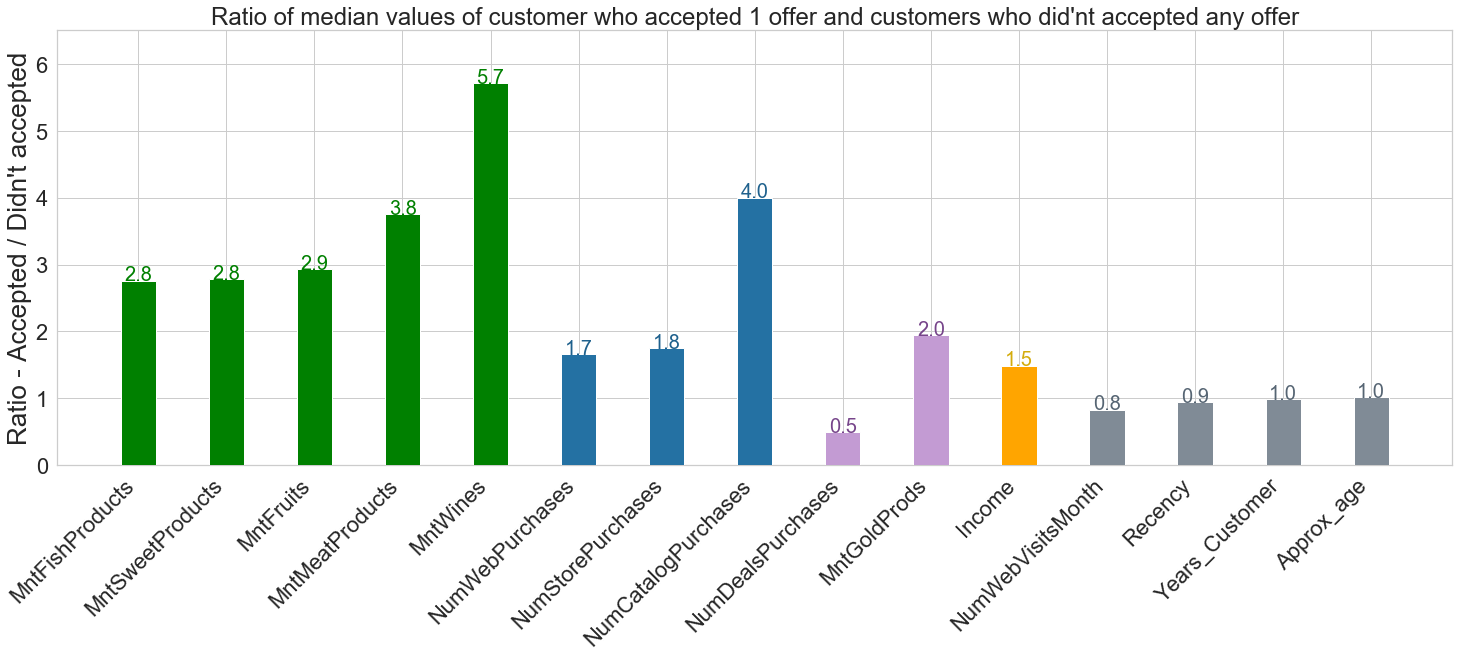

In [46]:
#Ploting the ratio values for the clients who accepted the offer / didn't accept any offer separated by categories
fig, ax = plt.subplots(figsize = (25,8))
vtext = np.vectorize(ax.text)

#Spending
x1 = med2.acc_no_acc.iloc[2:7].sort_values().index
y1 = med2.acc_no_acc.iloc[2:7].sort_values()

#Number of purchases
x2 = med2.acc_no_acc.iloc[9:12].sort_values().index
y2 = med2.acc_no_acc.iloc[9:12].sort_values()

#Deals and Gold prods
x3 = med2.acc_no_acc.iloc[7:9].sort_values().index
y3 = med2.acc_no_acc.iloc[7:9].sort_values()

#Income
x4 = med2.acc_no_acc.iloc[[0]].sort_values().index
y4 = med2.acc_no_acc.iloc[[0]].sort_values()

#Other features
x5 = med2.acc_no_acc.iloc[[1,12,13,14]].sort_values().index
y5 = med2.acc_no_acc.iloc[[1,12,13,14]].sort_values()


rects1 = ax.bar(x1,y1,width =-0.4,zorder=3,color='#008000',align='center')
rects1 = ax.bar(x2,y2,width =-0.4,zorder=3,color='#2471A3',align='center')
rects1 = ax.bar(x3,y3,width =-0.4,zorder=3,color='#C39BD3',align='center')
rects1 = ax.bar(x4,y4,width =-0.4,zorder=3,color='orange',align='center')
rects1 = ax.bar(x5,y5,width =-0.4,zorder=3,color='#808B96',align='center')


for i in range(len(y1)):  
    ax.text(x1[i], y1[i],np.str(np.round(y1[i],decimals=1)),fontsize =20,ha= 'center',color='#008000',rotation='horizontal')
for i in range(len(y2)):
    ax.text(x2[i], y2[i],np.str(np.round(y2[i],decimals=1)),fontsize =20,ha= 'center',color='#1F618D',rotation='horizontal')
for i in range(len(y3)):
    ax.text(x3[i], y3[i],np.str(np.round(y3[i],decimals=1)),fontsize =20,ha= 'center',color='#76448A',rotation='horizontal')
for i in range(len(y4)):
    ax.text(x4[i], y4[i],np.str(np.round(y4[i],decimals=1)),fontsize =20,ha= 'center',color='#D4AC0D',rotation='horizontal')
for i in range(len(y5)):
    ax.text(x5[i], y5[i],np.str(np.round(y5[i],decimals=1)),fontsize =20,ha= 'center',color='#566573',rotation='horizontal')
    


# organizing the labels and axis

ax.set_ylabel("Ratio - Accepted / Didn't accepted",fontsize=26)
ax.set_title("Ratio of median values of customer who accepted 1 offer and customers who did'nt accepted any offer",fontsize=24)


ax.set_ylim(0,6.5)

plt.xticks(fontsize = 22,rotation='45',ha='right')
plt.yticks(fontsize = 22)

ax.grid(zorder=0)


*Figure 9:* Ratio between the median values for the customers who accepted at least one offer x customers who didn't accepted any offer separated by categories.

# 2. Customer Segmentation

## 2.1 Reading the data

In [47]:
#Reading the data we prepared at the part 1 of the case
data = data_final
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Years_Customer,Marital_ID,Education_ID,Approx_age,Campaing
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,1,8.238193,0,2,63,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,6.732375,0,2,66,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,7.277207,1,2,55,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,6.803559,1,2,36,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,6.863792,2,4,39,0


In [48]:
data.shape

(2212, 32)

We have a DataFrame with **2212 rows** and **33 columns**

## 2.2 Preparing the data

For this segmentation I will take into account the **RFM** (Recency, Frequency and Monetary value) values of the customers, so we will know the best customers based on their historic behavior. \
The best clients will be the ones with high Frequency and Monetary values, meaning that they buy and spend more and with low Recency, meaning that they did a purchase not so long ago, being an active customers.
We already have the recency value in our data, but we need to calculate the Frequency and Monetary Value.

In [49]:
#Creating the DataFrame
data_rfm=pd.DataFrame()
data_rfm["ID"] = data.ID
data_rfm["Recency"] = data.Recency
data_rfm["Frequency"] = (data.NumCatalogPurchases+data.NumWebPurchases+data.NumStorePurchases)
data_rfm["Monetary"]=(data.MntFishProducts+data.MntFruits+data.MntMeatProducts+data.MntSweetProducts+data.MntWines)
data_rfm.head()

,ID,Recency,Frequency,Monetary
0,5524,58,22,1529
1,2174,38,4,21
2,4141,26,20,734
3,6182,26,6,48
4,5324,94,14,407


In [50]:
# Give a score value to which attribute accordingly to its quartile values. The higher the score, the better the client
data_rfm['r_score'] = pd.qcut(data_rfm['Recency'], 4, [4,3,2,1])
data_rfm['f_score'] = pd.qcut(data_rfm['Frequency'], 4, [1,2,3,4])
data_rfm['m_score'] = pd.qcut(data_rfm['Monetary'], 4, [1,2,3,4])
data_rfm.head()

,ID,Recency,Frequency,Monetary,r_score,f_score,m_score
0,5524,58,22,1529,2,4,4
1,2174,38,4,21,3,1,1
2,4141,26,20,734,3,4,3
3,6182,26,6,48,3,1,1
4,5324,94,14,407,1,3,3


In [51]:
data_rfm['r_score']=data_rfm.r_score.astype('int64')
data_rfm['f_score']=data_rfm.f_score.astype('int64')
data_rfm['m_score']=data_rfm.m_score.astype('int64')

## 2.3 Segmentation

In [52]:
#For this case the final score will be given by the sum of the 3 scores, giving the same weight for the 3 attributes
#The highest possible score is 12 and the lowest is 3
data_rfm['rfm_score'] = (data_rfm['r_score'] + data_rfm['f_score'] + data_rfm['m_score'])

In [53]:
#Let's label 5 groups based on the "rfm_score" value.
data_rfm['group'] = pd.cut(data_rfm['rfm_score'], [3,6,8,9,11,13],right = False, labels = ['Inferior','Low','Medium','High','Top'])

In [54]:
data_rfm.head()

,ID,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,group
0,5524,58,22,1529,2,4,4,10,High
1,2174,38,4,21,3,1,1,5,Inferior
2,4141,26,20,734,3,4,3,10,High
3,6182,26,6,48,3,1,1,5,Inferior
4,5324,94,14,407,1,3,3,7,Low


In [55]:
group_label=data_rfm.groupby(["group"])["ID"].nunique().reset_index()
group_label["perc_g"] = 100*(group_label.ID/(group_label.ID.sum()))

print(group_label)

      group   ID     perc_g
0  Inferior  592  26.763110
1       Low  486  21.971067
2    Medium  306  13.833635
3      High  549  24.819168
4       Top  279  12.613020


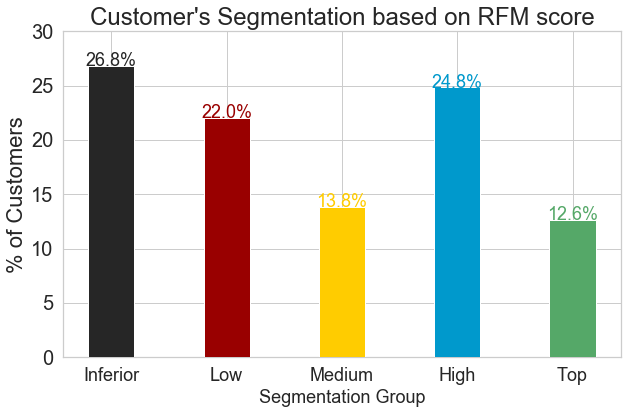

In [56]:
#Ploting the % of customer in each group
fig, ax = plt.subplots(figsize = (10,6))
vtext = np.vectorize(ax.text)

x1 = group_label.group
y1 = group_label.perc_g


my_colors=['#262626','#990000','#ffcc00','#0099cc','g']

for i in range(len(y1)):  
    ax.bar(x1[i],y1[i],width =-0.4,zorder=3,color=my_colors[i],align='center')
    ax.text(x1[i], y1[i],np.str(np.round(y1[i],decimals=1))+'%',fontsize =18,ha= 'center',color=my_colors[i],rotation='horizontal')
    


# organizing the labels and axis
ax.set_xlabel('Segmentation Group',fontsize=18)
ax.set_ylabel("% of Customers",fontsize=22)
ax.set_title("Customer's Segmentation based on RFM score",fontsize=24)

ax.set_ylim(0,30)
plt.xticks(fontsize = 18,rotation='horizontal',ha='center')
plt.yticks(fontsize = 20)

ax.grid(zorder=0)

*Figure 10:* % of Customers in each segmentation group

In [57]:
# Calculating the median value for the Recency, Frequency and Monetary value for each group
group_r=data_rfm.groupby(["group"])["Recency"].median().reset_index()
group_f=data_rfm.groupby(["group"])["Frequency"].median().reset_index()
group_m=data_rfm.groupby(["group"])["Monetary"].median().reset_index()

In [58]:
median_rfm=pd.merge(pd.merge(group_r,group_f,on='group'),group_m,on='group')
median_rfm

,group,Recency,Frequency,Monetary
0,Inferior,71.0,5,40
1,Low,34.5,7,117
2,Medium,63.0,14,498
3,High,51.0,19,996
4,Top,17.0,21,1235


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

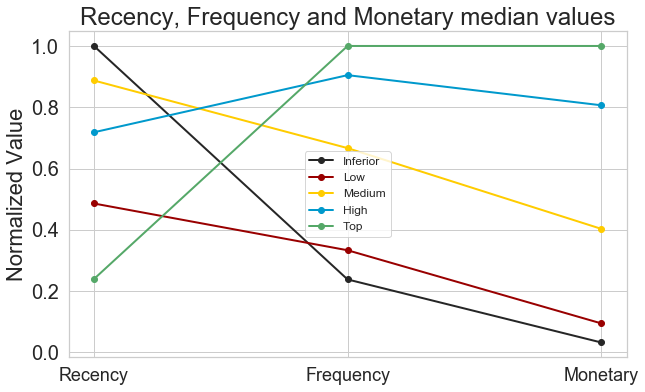

In [59]:
#Plot the normalized values (divided by the highest value) to compare the median value for each group
aux = median_rfm.values
aux

plt.figure(figsize = [10,6])
for i in range(aux.shape[1]+1):
    plt.plot(median_rfm.columns[1:],aux[i,1:]/aux[:,1:].max(0),linewidth = 2,marker='o',color=my_colors[i])

plt.legend(aux[:,0],fontsize = 12)
plt.grid(zorder=0)

plt.ylabel("Normalized Value",fontsize=22)
plt.title("Recency, Frequency and Monetary median values",fontsize=24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)

*Figure 11:* Normalized values (divided by the highest value) to compare the median values of Recency, Frequency and Monetary value for each group

As we can see, the "Top" group has the highest values for Frequency and Monetary value and lowest Recency, representing our best customers, while the "inferior" group would be the clients who bought and spent less and didn't buy for a longer time. It is interesting to notice that the "High" group has a Recency median value greater than the "Low" group, but much better values for the Frequency and Recency. 

In [60]:
#Merge the score with Campaign acceptance and responde
Merge=(pd.merge(data_rfm,data[['ID','Response','Campaing']],how='left',left_on="ID",right_on='ID'))
Merge.head()

,ID,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,group,Response,Campaing
0,5524,58,22,1529,2,4,4,10,High,1,0
1,2174,38,4,21,3,1,1,5,Inferior,0,0
2,4141,26,20,734,3,4,3,10,High,0,0
3,6182,26,6,48,3,1,1,5,Inferior,0,0
4,5324,94,14,407,1,3,3,7,Low,0,0


In [61]:
#Clients who accepted at least one offer
#Accepted at least 1 offer
camp = Merge[Merge.Campaing>0]
#Respondants of the 6th Campaing
resp = Merge[Merge.Response>0]

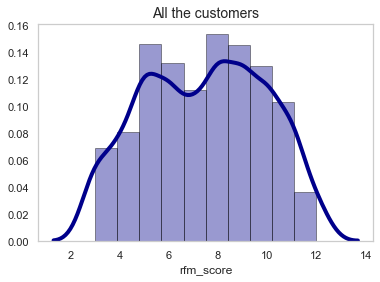

In [62]:
#rfm_score distribution with all the customers 
plt.figure(figsize = [6,4])
sns.distplot(data_rfm['rfm_score'], hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             
             kde_kws={'linewidth': 4})
plt.title("All the customers",fontsize=14)
plt.grid(b=None)


*Figure 12:* rfm_score distribution of all customers

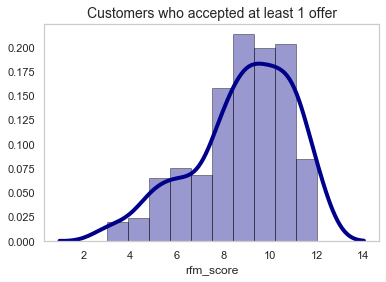

In [63]:
#rfm_score distribution with the customers who accepted at least one offer
plt.figure(figsize = [6,4])
sns.distplot(camp['rfm_score'], hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             
             kde_kws={'linewidth': 4})
plt.title("Customers who accepted at least 1 offer",fontsize=14)
plt.grid(b=None)


*Figure 13:* rfm_score distribution of the customers who accepted at least 1 offer

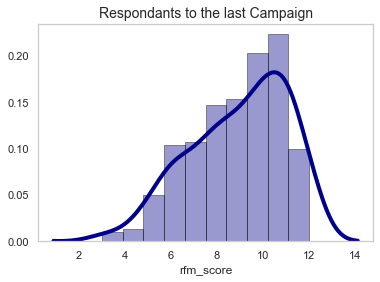

In [64]:
#rfm_score distribution with the customers who accepted the 6th Campaign
plt.figure(figsize = [6,4])
sns.distplot(resp['rfm_score'], hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             
             kde_kws={'linewidth': 4})
plt.title("Respondants to the last Campaign",fontsize=14)
plt.grid(b=None)

*Figure 14:* rfm_score distribution of the customers who respond to the last campaing

Comparing the 3 distributions, we can see that the customers who participate on the campaings have higher scores than the entire customer's base. So, with that simple segmentation we could increase the ROI of the campaing by selecting only our best customers, let's say, the Medium, High and Top group:

In [65]:
#Only the best clients (Top, High and Medium)
best=Merge[Merge.rfm_score >=8]

In [66]:
#Comparing the contacted customers considering the entire base and only the best customers
Comparing = pd.DataFrame()

Comparing['Unique_Customers'] = [Merge.ID.nunique(), best.ID.nunique(),100*(Merge.ID.nunique()-best.ID.nunique())/Merge.ID.nunique()]
Comparing['Gadgets_sold'] = [Merge.Campaing.sum(),best.Campaing.sum(),100*(Merge.Campaing.sum()-best.Campaing.sum())/Merge.Campaing.sum()]
#Comparing['Best_Customers'] = [best.ID.nunique()]
Comparing.index = ['All_Customers','Best_Customers', 'Difference(%)']

In [67]:
Comparing.round(2)

,Unique_Customers,Gadgets_sold
All_Customers,2212.00,660.00
Best_Customers,1134.00,552.00
Difference(%),48.73,16.36


Using this simple customer's segmentation, if from the Campaign 1 we considered contacting only the Top, High and Medium group that represent our most active and loyal customers, we would reduce the contact costs in 48.7% and the revenue would decrease in only 16.4%.By focusing only on the more engaged customer, we would increase the **ROI** of the Campaign from **-45%** to **-11%**. Still not the ideal situation, but already much better. 

# 3. Predictive Model

As we have a two-class classification problem, we will use **Logistic Regression** to predict the probability of the customer to accept or not the offer on the next campaign.

In [68]:
#I will use the data we prepared on the 1st part of this notebook and the rfm_score calculated on the 2nd part
data=pd.merge(data_final,Merge[['ID','rfm_score']], how= 'left', on = "ID")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Years_Customer,Marital_ID,Education_ID,Approx_age,Campaing,rfm_score
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,1,8.238193,0,2,63,0,10
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,6.732375,0,2,66,0,5
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,7.277207,1,2,55,0,10
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,6.803559,1,2,36,0,5
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,6.863792,2,4,39,0,7


In [69]:
#Drop the columns that we transformed in other 
#(Year_Birthday -> Approx_age; Education -> Education_ID; Marital_Status -> Marital_ID; Dt_Customer -> Years_Customer)
data=data.drop(['Year_Birth', 'Education','Marital_Status','Dt_Customer'], axis = 1)
data.head()

,ID,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Years_Customer,Marital_ID,Education_ID,Approx_age,Campaing,rfm_score
0,5524,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,1,8.238193,0,2,63,0,10
1,2174,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,6.732375,0,2,66,0,5
2,4141,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,7.277207,1,2,55,0,10
3,6182,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,6.803559,1,2,36,0,5
4,5324,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,6.863792,2,4,39,0,7


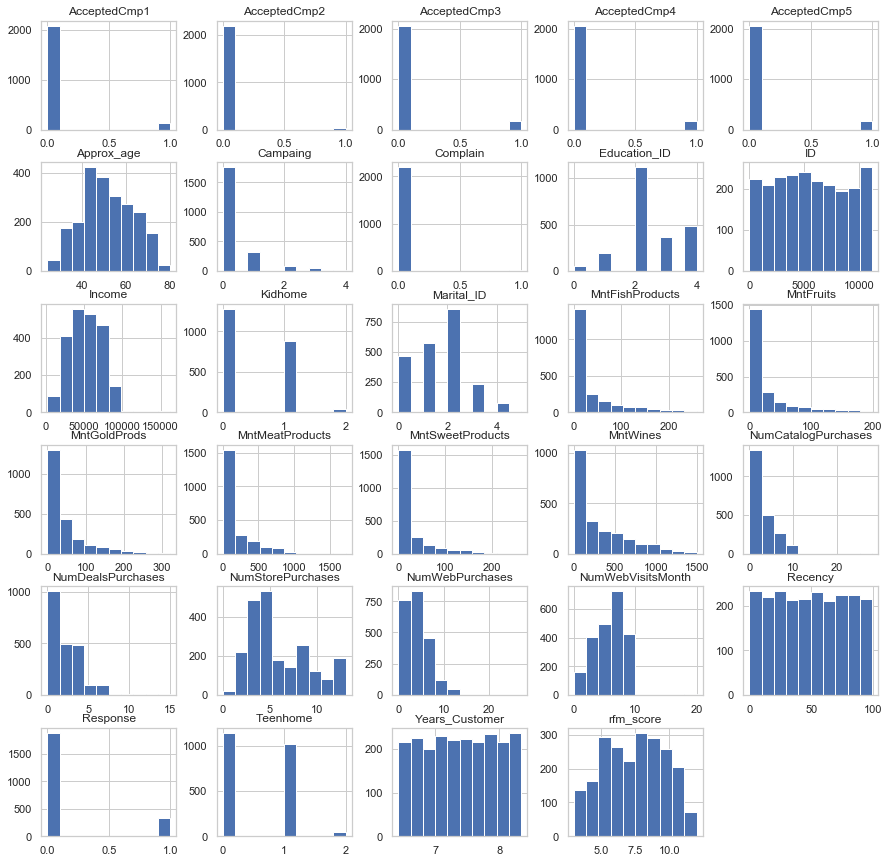

In [70]:
#Let's see the distribution of the variables
data.hist(figsize=[15,15]);

*Figure 15:* Variables histograms 

The logistic regression assumes a linear relationship between the independent variables with the dependent variable. So we can use data transforms of the independent variables to normal distribution to better expose de linear relationship and have a more accurate model.

In [71]:
PT = data.drop(['ID','Response'],axis=1)

In [72]:
def plot_power_transformed_feature(df, var, PT):
    plt.figure(figsize=[15,5])
    plt.subplot(121)
    plt.hist(df[var])
    plt.title(var + ' before P. Trans.')
    
    plt.subplot(122)
    pt = PT.fit_transform(df[[var]]).flatten()
    plt.hist(pt)
    plt.title(var + ' after P. Trans.')

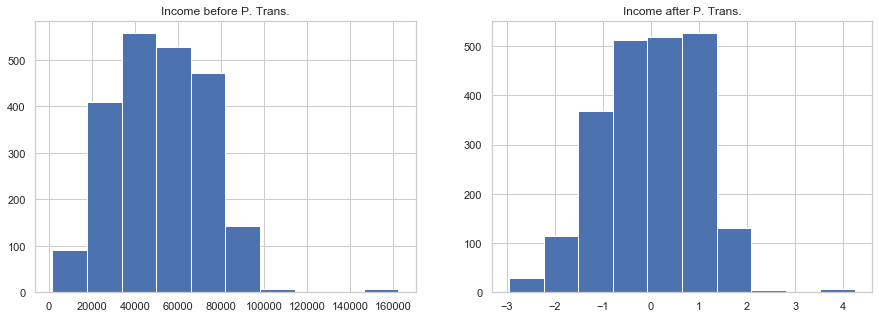

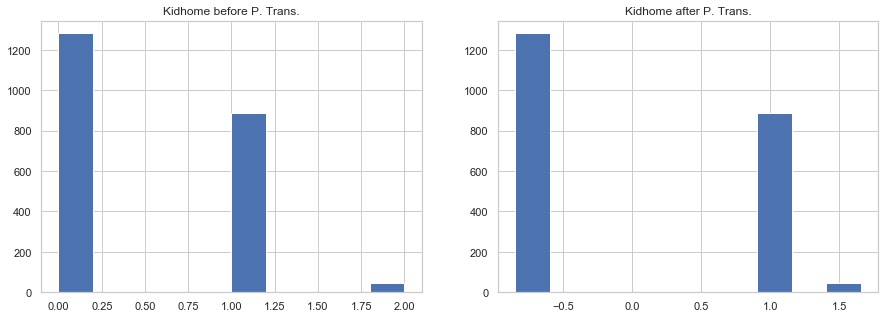

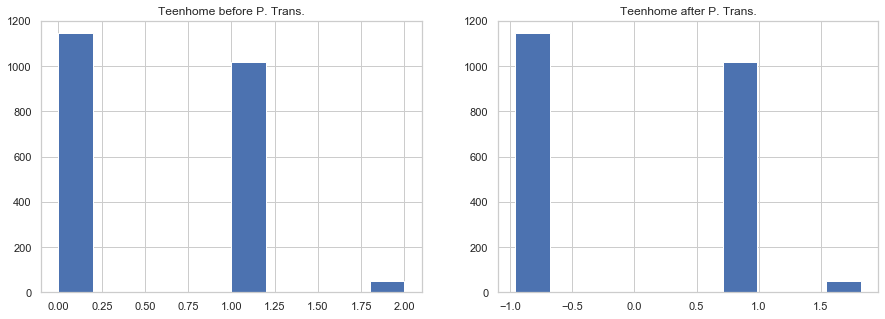

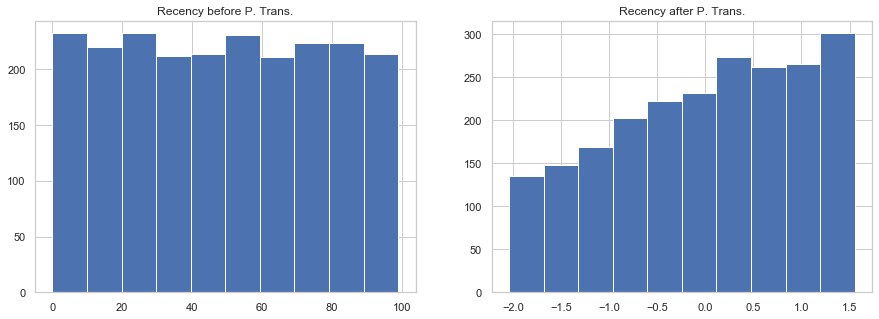

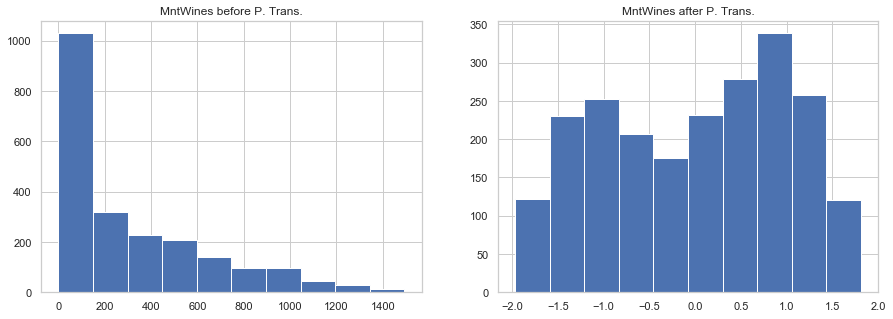

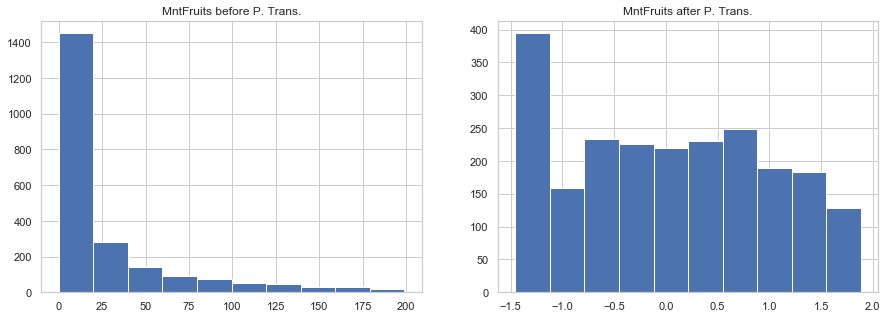

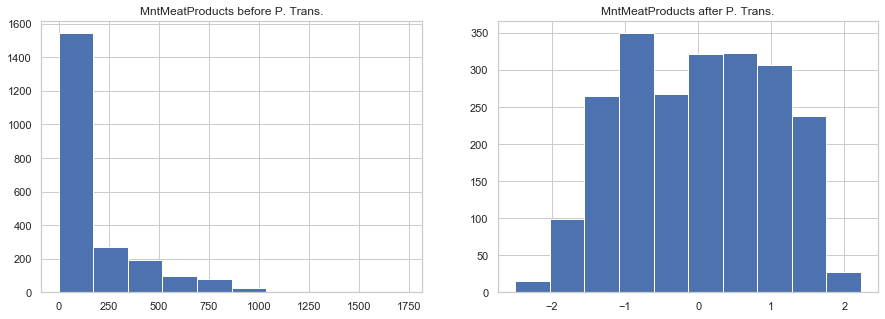

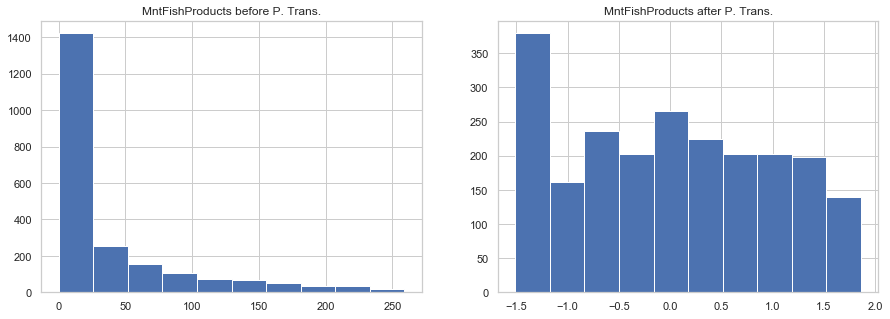

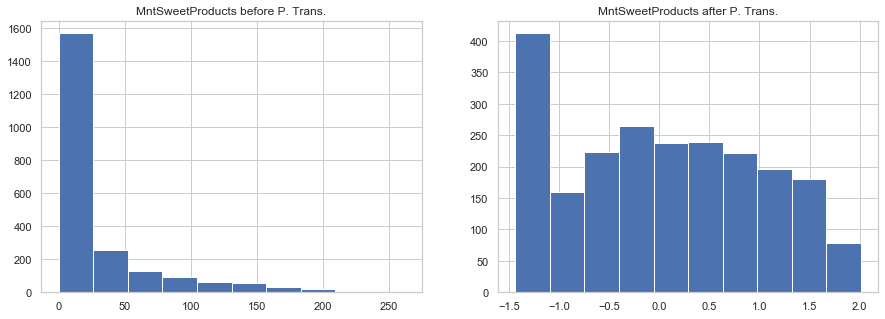

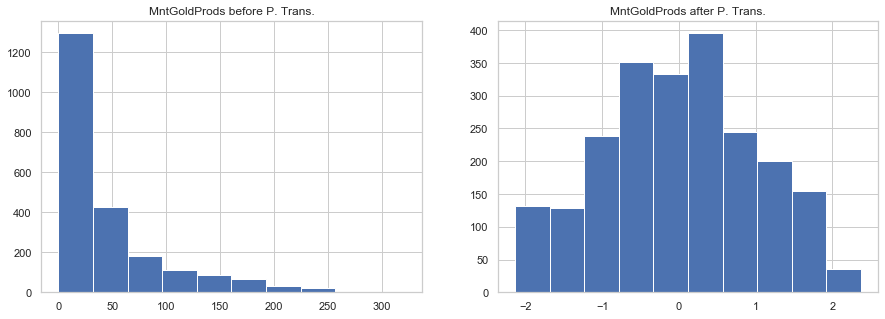

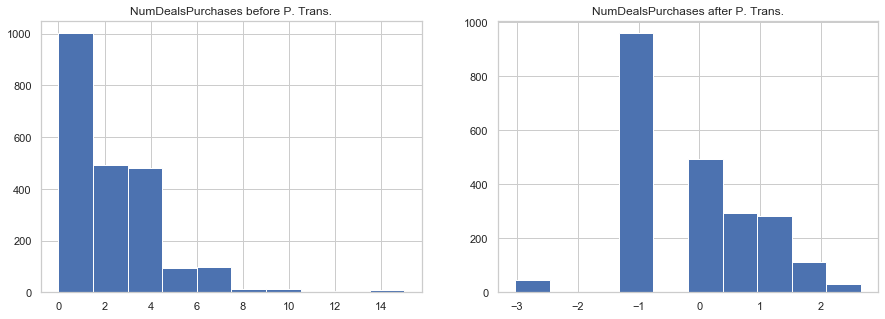

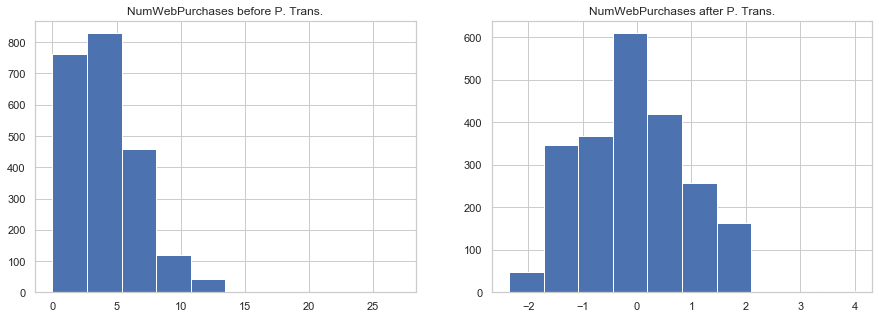

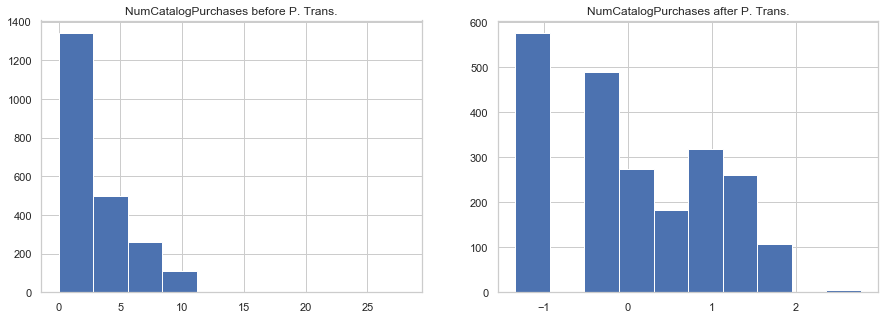

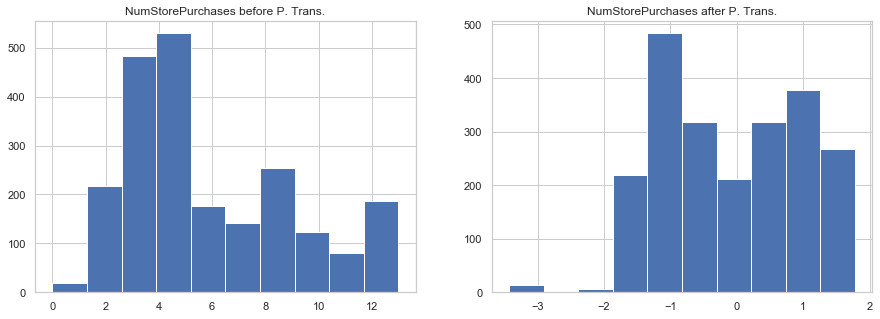

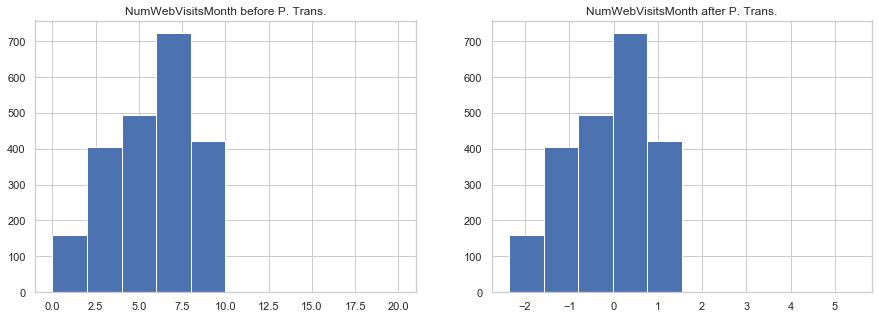

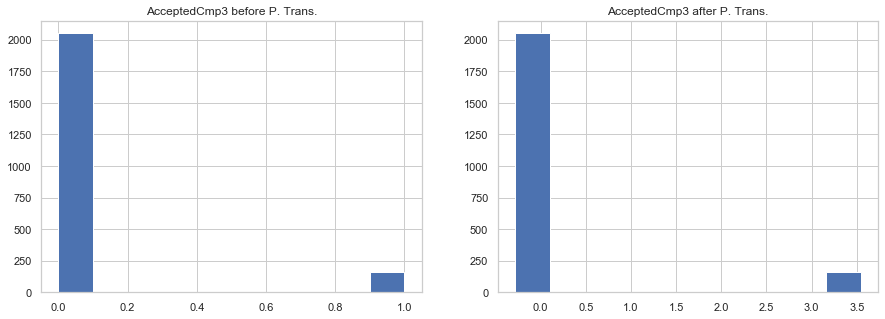

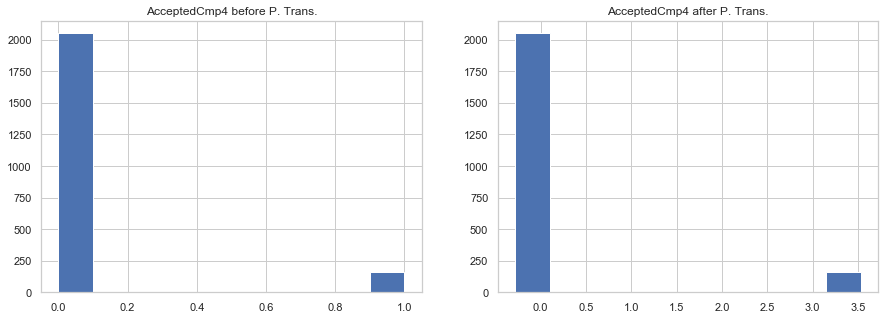

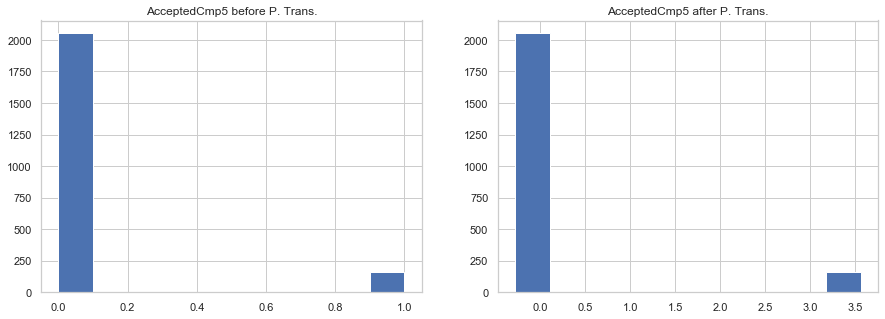

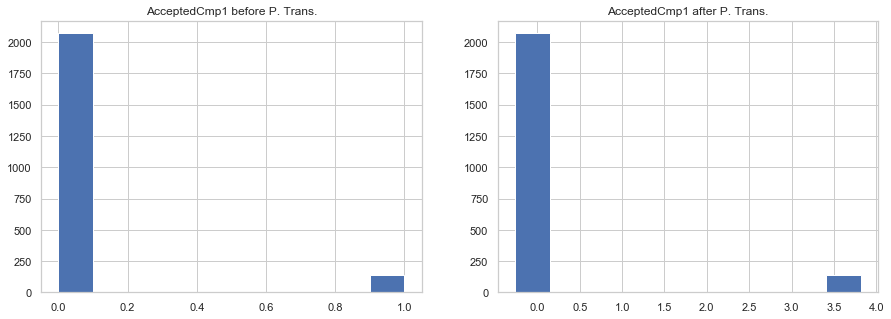

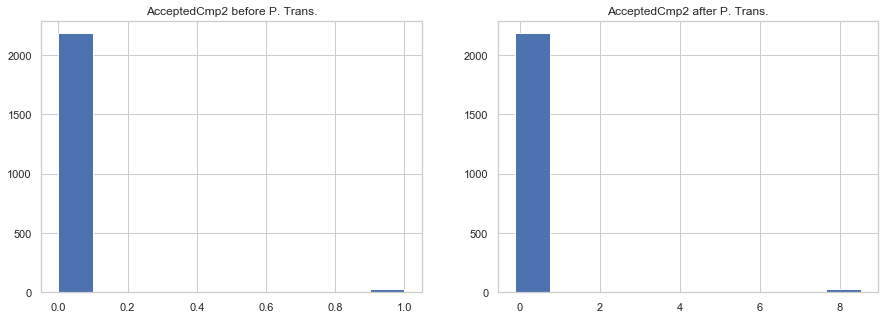

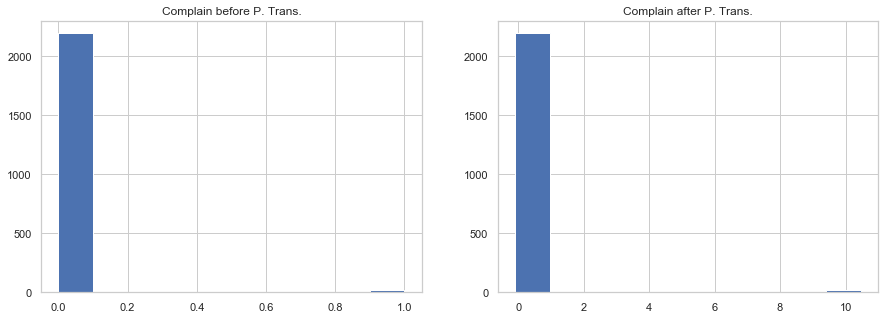

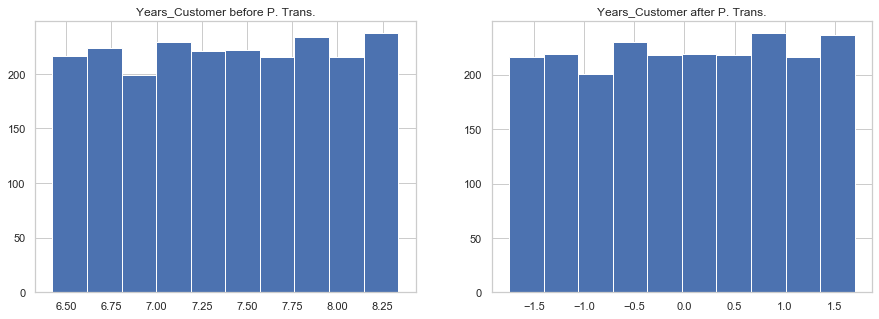

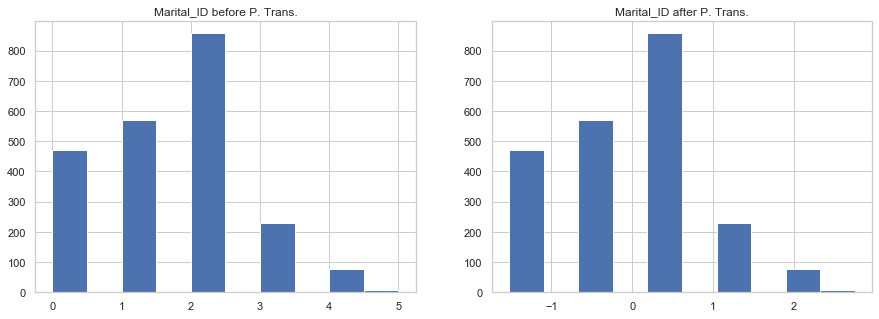

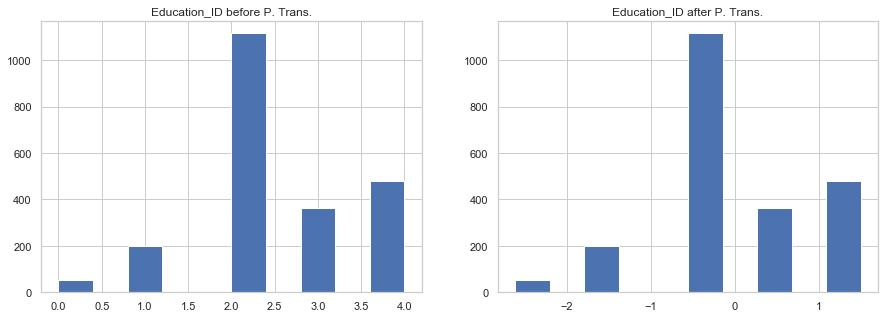

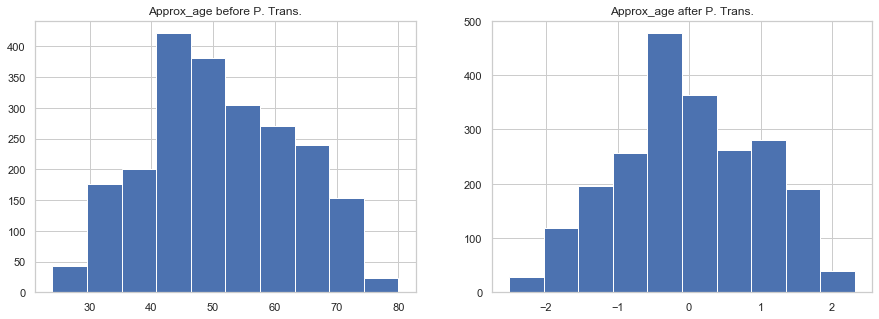

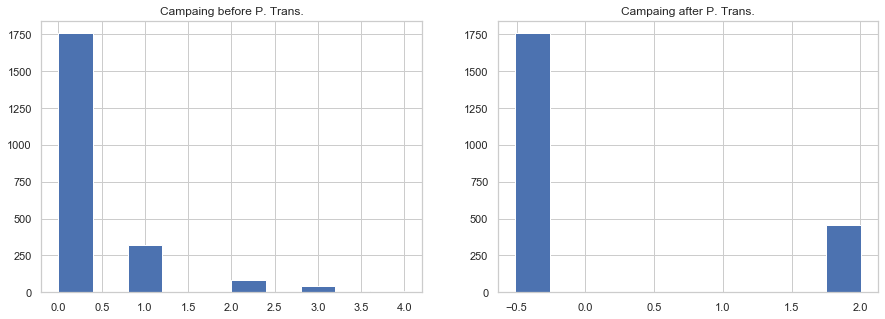

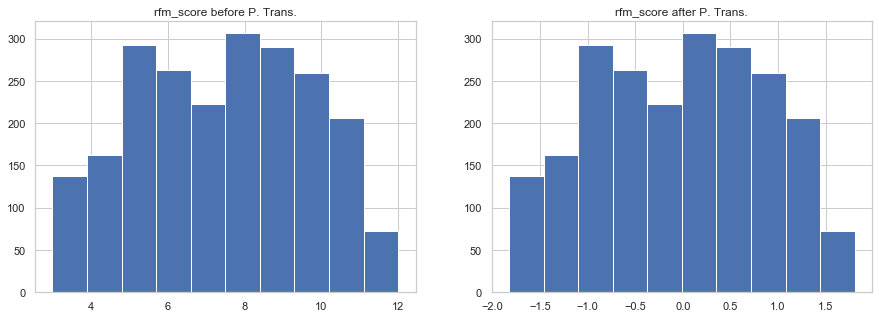

In [73]:
for col in PT.columns:
    plot_power_transformed_feature(PT,col,PowerTransformer())

*Figure 16:* Histograms before and after Power Transformation

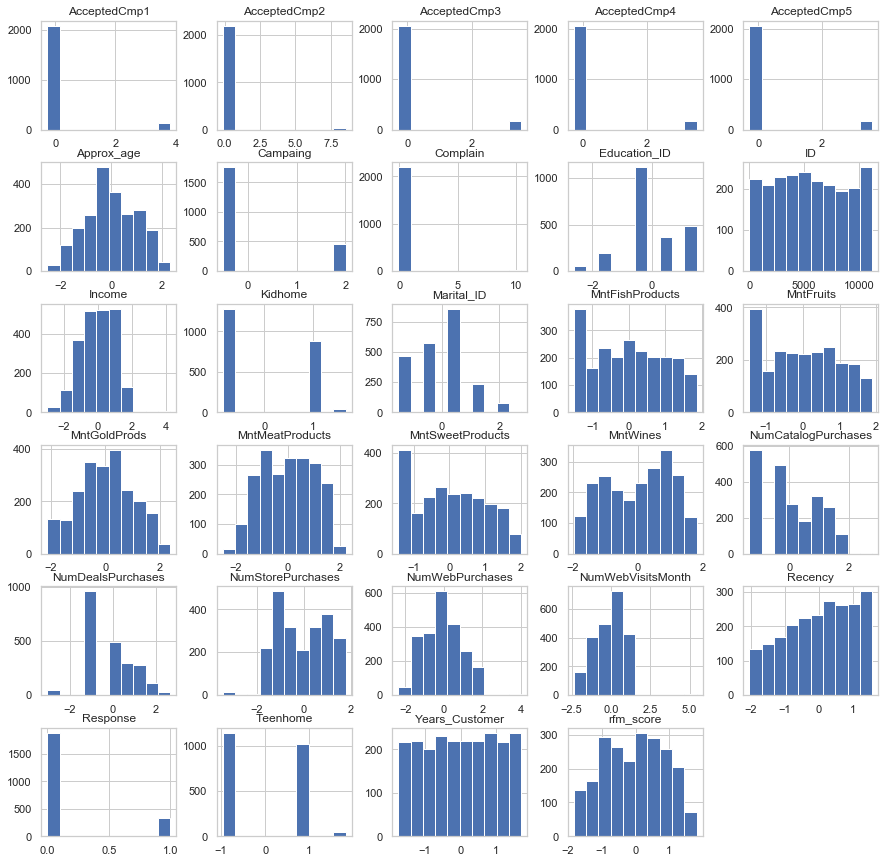

In [74]:
#Saving the DataFrame with the Transform values
data_PT = data
for col in PT.columns:
    data_PT[col] = PowerTransformer().fit_transform(data[[col]]).flatten()
data_PT.hist(figsize=[15,15]);

data = data_PT

*Figure 16:* Variables distribution after the Power Transformation

In [169]:
#Let's rank the correlation of the variables with our target
data_cor=abs(data.corr()['Response']).sort_values(ascending=False)
data_cor=data_cor.to_frame()
data_cor

,Response
Response,1.000000
Campaing,0.370783
AcceptedCmp5,0.324891
AcceptedCmp1,0.297212
rfm_score,0.257399
AcceptedCmp3,0.253849
NumCatalogPurchases,0.232756
MntMeatProducts,0.222997
Recency,0.205656
Years_Customer,0.196045


In [216]:
#For the model I will select the features with higher correlation with the target.
#Excluded Features: Complain, NumWebVisitMonth, ID, Approx_age, Marital_ID,NumDealsPurchases and NumStorePurchases
Features_to_use = data_cor.index[1:22].values
Features_to_use

array(['Campaing', 'AcceptedCmp5', 'AcceptedCmp1', 'rfm_score',
       'AcceptedCmp3', 'NumCatalogPurchases', 'MntMeatProducts',
       'Recency', 'Years_Customer', 'MntWines', 'AcceptedCmp4',
       'MntGoldProds', 'AcceptedCmp2', 'NumWebPurchases', 'Teenhome',
       'Income', 'MntFruits', 'MntSweetProducts', 'MntFishProducts',
       'Education_ID', 'Kidhome'], dtype=object)

Those are the features we will use in the model in order of relevance to the Reponse. 

In [217]:
#Setting the independents and dependent variables
X = data[Features_to_use].values
Y = data['Response'].values

print(X.shape)
print(Y.shape)

(2212, 21)
(2212,)


In [218]:
#Separate the data to train and to test (70/30)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(1548, 21)
(1548,)
(664, 21)
(664,)


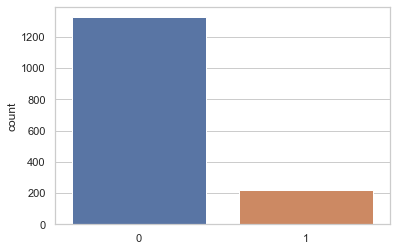

In [220]:
#On our train dataset, we have much more clients that didn't respond to the Campaign, so we will need to resample our data
#so both classes not represented equally.
plt.figure(figsize = [6,4])
sns.countplot(x = Y_train)

*Figure 17:* The training set is imabalanced

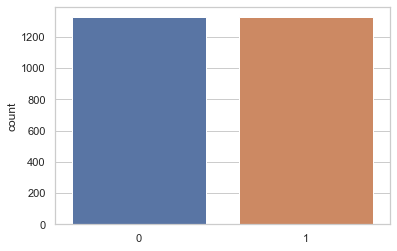

In [224]:
#Using the oversampling technique
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

plt.figure(figsize = [6,4])
sns.countplot(x = Y_train)

*Figure 18:* Now the training set is balanced

In [225]:
#Let's use de logical regression model
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(random_state=10, solver='liblinear').fit(X_train,Y_train)

In [226]:
#Predict Values
model_LR.predict(X_train)

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [227]:
#Probabilities to not accept and accept the offer
model_LR.predict_proba(X_train)

array([[0.98294191, 0.01705809],
       [0.72663755, 0.27336245],
       [0.20552399, 0.79447601],
       ...,
       [0.66506679, 0.33493321],
       [0.34724362, 0.65275638],
       [0.1356312 , 0.8643688 ]])

In [228]:
#Accuracy of our model
model_LR.score(X_test,Y_test)

0.8147590361445783

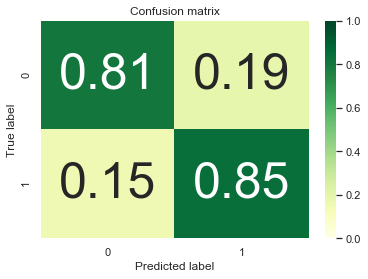

In [244]:
#Let's check the Confusion matrix

from sklearn.metrics import confusion_matrix
cm_model_LR = confusion_matrix(Y_test, model_LR.predict(X_test))

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGn", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#in percentage
cm_model_LR_fract = cm_model_LR / cm_model_LR.sum(axis=1).reshape(-1,1)
cm_model_LR_percent = 100*cm_model_LR_fract

#Visualizing the confusion matrix
plt.figure(figsize = [6,4])
plot_confusion_matrix(cm_model_LR_fract, classes = model_LR.classes_, title='Confusion matrix')

*Figure 19:* Confusion Matrix of the predictions.

As we can see, our model correctly predicted 81% of the customers who didn't accept the offer and 85% of the customers who accepted the offer on the last campaign.